In [1]:
%load_ext autoreload 
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import pandas as pd
from glob import glob
import datetime as dt
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
from metpy.units import units
from typing import Tuple
import dask

#Personal functions
from function import preprocessUtils as putils
from function import conf
from glob import glob
from function import masks
from function import quikplot as qp



/glade/work/klesinger/conda-envs/tf212gpu_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# This script should work for creating data which has the correct format as GEFSv12 forecast. Eventually we will save the data according to only GEFSv12 format (35 days), but this will work for all regions and also for ECMWF

# Notes

In [2]:
'''
1.) Needs about 50GB RAM for CONUS (shape of file is 48 x 96 lat/lon)

Select a specific region (either CONUS, australia, or china)

Takes about 2 hours to fully complete everything.
'''

''' 
GEFSv12 reforecast appears to have some missing values for some init dates. 
We are replacing those with the mean because this is messing up min/max scaling
very badly
'''

' \nGEFSv12 reforecast appears to have some missing values for some init dates. \nWe are replacing those with the mean because this is messing up min/max scaling\nvery badly\n'

# Setup

In [3]:
'''For reformatting the observations to the same lead-time format as GEFSv12.
if True, then it will re-write the files (this is useful in case of error or new files introduced'''
re_run_OBS_reformat_to_SubX = True 

plot_distribution = False #This set of functions takes a long time to plot. But if you want to see the anomaly and min-max distribution, select True

In [4]:
global rzsm_source
rzsm_source = 'ERA5' #['ERA5','GLEAM']

# Set information regarding what region, what reforecast input, and the dates

In [5]:
global fcst_dir_for_template

region_name = 'china' #or ['australia', 'CONUS', 'china']

reforecast_input = 'GEFSv12'  #['GEFSv12', 'ECMWF']


global base_reanalysis
gleam_dir, era5_dir, fcst_dir, base_reanalysis = conf.return_data_directories(reforecast_input, region_name)

#used as a base template for creating new files
fcst_dir_for_template = f"{conf.gefsv12_data}/{region_name}"


global verification_var
# verification_var = 'soilw_bgrnd_GLEAM' #this is for what we are verifying with DL outputs. We have previously named a file this.
verification_var = f'soilw_bgrnd_{rzsm_source}'

if verification_var == 'soilw_bgrnd_GLEAM':
    soil_dir = gleam_dir
elif verification_var == 'soilw_bgrnd_ERA5':
    soil_dir = era5_dir


In [7]:

start_date = '1999-01-01' #for reanalysis data. Select earlier dates than the forecasts to allow for smoothing and because we need lagged observations
end_date = '2020-03-01' #for reanalysis data, select at least 45 days after the end of the forecasts to allow for comparison

#For metpy functions
spfh_unit = 'kg/kg' #Make sure that our reforecast and observation have the same unit for specific humidity


# Set data for training, validation, testing

In [8]:
#Set years for training, validation, and testing
train_end = 2015 #will grab everything before train_end (including train_end year)
val_end = 2017 #will grab everything after train_end and before val_end
test_start = 2018 #takes everything after test_start

# Data directory locations and parameters

In [9]:

#Get initialized dates from GEFSv12 to convert observations for easier stacking
global init_date_list

#Forecast predictions
#Only use GEFSv12 dates
init_date_list = putils.get_init_date_list(forecast_variable_path=f'{fcst_dir_for_template}/soilw_bgrnd/')

init_date_list_datetime = [pd.to_datetime(i) for i in init_date_list]

global var_list, var_list_obs, var_list_ref

#for observations
var_list_obs = ['soilw_bgrnd', 'tmax_2m', 'spfh_2m', 'pwat_eatm','diff_temp_2m','hgt_pres']

if reforecast_input == 'GEFSv12':
    var_list_ref = var_list_obs #Observation variables to pre-process
elif reforecast_input == 'ECMWF':
    var_list_ref = ['soilw_bgrnd','d2m', 't2m', 'tcw']



global lead_select
lead_select = [6,13,20,27,34] #For subsetting data by leads

'''Daily lags for observations -  we can specify up to 12 weeks in lagged RZSM data (these are 7-day increments). 
You can select whatever values you want (as long as they are before the reforecast period'''
daily_lags = putils.make_daily_lags()

# Get mask of land/ocean areas

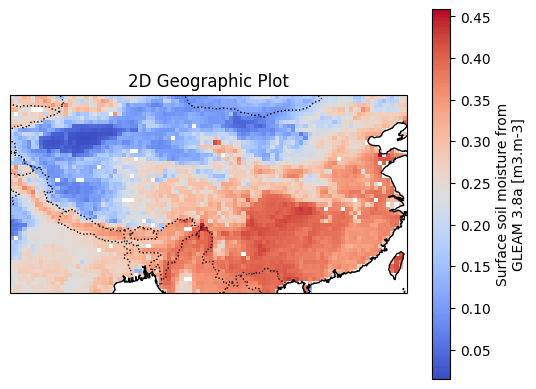

In [10]:
mask,mask_vals = masks.load_mask_vals(region_name) #Load the mask xarry and mask numpy files. Values of 1 = land 
qp.d2_plot(mask[putils.xarray_varname(mask)][0,:,:])

# Load Observation Data files

In [11]:
print(f'Loading observations. Applying a 7-day rolling mean between {start_date} and {end_date} for {region_name} Region.')

if verification_var == 'soilw_bgrnd_GLEAM':
    name_print = 'GLEAM_RZSM_obs'
else:
    name_print = 'ERA5_RZSM_obs'
    
RZSM_obs,proper_date_time = putils.open_reanalysis_files_and_preprocess_rolling_mean_RZSM_only(path_to_file=f'{soil_dir}/RZSM_weighted_mean_0_100cm.nc4',
                                                                 file_variable=name_print,start_date=start_date,end_date=end_date,region_name = region_name)

precipitable_water_ERA = putils.open_reanalysis_files_and_preprocess_rolling_mean_other_files(path_to_file=f'{era5_dir}/total_column_water_merged.nc4',
                                                             file_variable='ERA_precipitable_water_obs',start_date=start_date,end_date=end_date,
                                                               region_name = region_name, proper_date_time=proper_date_time)

geopotential_z200_ERA = putils.open_reanalysis_files_and_preprocess_rolling_mean_other_files(path_to_file=f'{era5_dir}/geopotential_merged.nc4',
                                                             file_variable='ERA_geopotential_z200_obs',start_date=start_date,end_date=end_date,
                                                               region_name = region_name, proper_date_time=proper_date_time)

max_temp_ERA, diff_temp_ERA = putils.open_temperature_files_and_preprocess_rolling_mean(path_to_tmax =f'{era5_dir}/maximum_2m_temperature_merged.nc4', 
                                                                                 path_to_tmin =f'{era5_dir}/minimum_2m_temperature_merged.nc4',
                                                                                 file_variable_tmax = 'ERA_Tmax_obs',file_variable_tmin = 'ERA_Tmin_obs',
                                                                                 start_date=start_date, end_date=end_date, 
                                                                                 region_name = region_name, proper_date_time=proper_date_time)

spfh_ERA = putils.calculate_2m_specific_humidity_and_preprocess(path_to_dewpoint=f'{era5_dir}/2m_dewpoint_temperature_merged.nc4', 
                                              path_to_pressure=f'{era5_dir}/surface_pressure_merged.nc4', 
                                              file_variable_dewpoint='ERA_2m_dewpoint_obs', file_variable_pressure='ERA_surface_pressure_obs', 
                                              start_date=start_date, end_date=end_date, 
                                              region_name = region_name, proper_date_time=proper_date_time,
                                              obs_dir = era5_dir, spfh_unit = spfh_unit)

print('Loaded all observations.')

Loading observations. Applying a 7-day rolling mean between 1999-01-01 and 2020-03-01 for china Region.

Latitude values for mask is [44.  43.5 43.  42.5 42.  41.5 41.  40.5 40.  39.5 39.  38.5 38.  37.5
 37.  36.5 36.  35.5 35.  34.5 34.  33.5 33.  32.5 32.  31.5 31.  30.5
 30.  29.5 29.  28.5 28.  27.5 27.  26.5 26.  25.5 25.  24.5 24.  23.5
 23.  22.5 22.  21.5 21.  20.5]

Longitude values for mask is [ 74.5  75.   75.5  76.   76.5  77.   77.5  78.   78.5  79.   79.5  80.
  80.5  81.   81.5  82.   82.5  83.   83.5  84.   84.5  85.   85.5  86.
  86.5  87.   87.5  88.   88.5  89.   89.5  90.   90.5  91.   91.5  92.
  92.5  93.   93.5  94.   94.5  95.   95.5  96.   96.5  97.   97.5  98.
  98.5  99.   99.5 100.  100.5 101.  101.5 102.  102.5 103.  103.5 104.
 104.5 105.  105.5 106.  106.5 107.  107.5 108.  108.5 109.  109.5 110.
 110.5 111.  111.5 112.  112.5 113.  113.5 114.  114.5 115.  115.5 116.
 116.5 117.  117.5 118.  118.5 119.  119.5 120.  120.5 121.  121.5 122. ]
Loaded mask
Re

In [12]:


soil_anom = f'{soil_dir}/RZSM_anomaly.nc'

if os.path.exists(soil_anom):
    combined_files = xr.open_dataset(soil_anom)
else:
    #Print saving the anomaly for each region as the standard format
    climatology_season = RZSM_obs.sel(time=(RZSM_obs['time.year'] <= train_end)).groupby(f"time.season").mean()
    
    summer_ = RZSM_obs.sel(time=(RZSM_obs['time.season'] == 'JJA')) - climatology_season.sel(season='JJA')
    fall_ = RZSM_obs.sel(time=(RZSM_obs['time.season'] == 'SON')) - climatology_season.sel(season='SON')
    winter_ = RZSM_obs.sel(time=(RZSM_obs['time.season'] == 'DJF')) - climatology_season.sel(season='DJF')
    spring_ = RZSM_obs.sel(time=(RZSM_obs['time.season'] == 'MAM')) - climatology_season.sel(season='MAM')
    
    combined_files = xr.concat([summer_,fall_,winter_,spring_],dim='time').sortby('time')
    combined_files=combined_files.astype(np.float32)
    
    combined_files.to_netcdf(soil_anom)

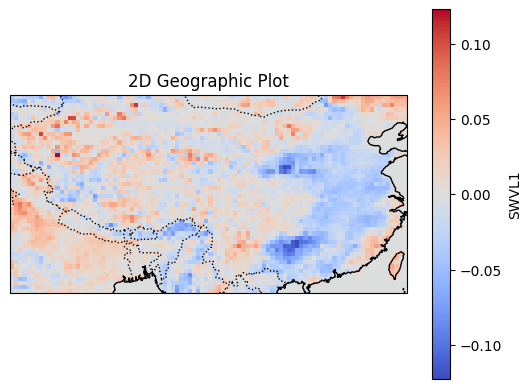

In [13]:
#quick plot of combined files
qp.d2_plot(combined_files[putils.xarray_varname(combined_files)][20,:,:])

# Now restructure the observation data to the same lead-time format as GEFSv12. This will allow for an easier computation of anomalies using climpred functions.

### New indexes will be from range (-84 days to -1 day and then the typical 7-day lead times starting from 0 to 34). Because we have applied a 7-day rolling mean to observations so far, even index -1 for the day has the data from the previous 7-days.

In [14]:
global template
#Grab a single SubX to use as the template. Doesn't matter if it is the same variable or not or the same date

template = sorted(glob(f'{fcst_dir_for_template}/soilw_bgrnd/*.n*'))[0]
template = xr.open_dataset(template)

In [15]:
def return_info_for_processing(var: str, verification_var: str) -> Tuple[str, xr.DataArray]:
    #Names to save the data so that it is in the exact same format as the Reforecasts
    
    if var == 'soilw_bgrnd':
        # var_name = var #var_name is the actual name of the variable in the xarray file
        if "GLEAM" in verification_var:
            model_name = 'GLEAM' #source of the data
        elif "ERA5" in verification_var:
            model_name = "ERA5"
        obs_file = RZSM_obs #the actual data file
    elif var == 'tmax_2m':
        # var_name = 'tasmax'
        model_name = 'ERA5'
        obs_file = max_temp_ERA
    elif var == 'spfh_2m':
        # var_name = 'huss'
        model_name = 'ERA5'
        obs_file = spfh_ERA
    elif var == 'pwat_eatm':
        # var_name = 'precipitable_water'
        model_name = 'ERA5'
        obs_file = precipitable_water_ERA
    elif var == 'diff_temp_2m':
        # var_name = 'diff_tmax_tmin'
        model_name = 'ERA5'
        obs_file = diff_temp_ERA
    elif var == 'hgt_pres':
        # var_name = 'z'
        model_name = 'ERA5'
        obs_file = geopotential_z200_ERA
    
    output_OBSERVATIONS_reformat_dir = f'{base_reanalysis}/{model_name}/{region_name}/reformat_to_reforecast_shape' #Directory to save 
    save_dir = f'{output_OBSERVATIONS_reformat_dir}/{var}'
    
    os.system(f'mkdir -p {save_dir}')
    
    return(model_name,obs_file,output_OBSERVATIONS_reformat_dir,save_dir)



def convert_OBS_to_SubX_format(_date: str, verification_var: str) -> None:  
# for _date in init_date_list:
    # var='RZSM_weighted'
    # _date=init_date_list[0]

    
    '''We are going to create new leads that are different than reforecast. The reasoning for this is that we want the actual weekly lags (and 1 day lag) and this will
    assist with future predictions within the deep learning model'''

    if region_name == 'CONUS':
        #Currently the GLEAM and ERA observations are in a format with only positive values for the longitude.
        #The current reforecast has negative values for those West of 0 degrees
        
        new_X_coords = putils.create_new_X_coord_values(template)
        single_file = template.assign_coords({'X':new_X_coords})
        single_file = xr.zeros_like(single_file)
        open_date_SubX = putils.restrict_to_bounding_box(single_file,mask)
        
    elif region_name != 'CONUS':
        open_date_SubX = template
        open_date_SubX = xr.zeros_like(open_date_SubX)
    
    for var in var_list_obs:
        # break
        model_name, obs_file, output_OBSERVATIONS_reformat_dir, save_dir = return_info_for_processing(var, verification_var)     

        obs_file_name = f'{var}_reformat_{reforecast_input}_{_date}.nc4'
        save_file = f'{save_dir}/{obs_file_name}'
        
        # os.system(f'rm {save_file}')
        if os.path.exists(save_file):
            print(f'Completed date {_date}')
            pass
        else:
            # print(f'Working on variable {var} for date {_date}')
            out_file = open_date_SubX.copy(deep=True)
    
            '''We are going to create a new lead day that represents the previous day before the forecast was initialized
            #New shape will be (1x11x48xlatxlon)
            This will include the day lag 1, and weekly lags 1-12'''
            
            file_shape = out_file[putils.xarray_varname(out_file)].shape
            
            named_str_leads = [str(i) for i in np.arange(-1,open_date_SubX.L.shape[0])]
            new_shape = np.empty(shape=(1,file_shape[1],file_shape[2]+13,file_shape[3],file_shape[4]))
            new_shape.shape
            
            daily_lead_lags = daily_lags + list(out_file.L.values[:])
            
            new_lead_days = xr.Dataset(
                data_vars = dict(
                    test = (['S','M','L','Y','X'], new_shape[:,:,:,:,:]),
                ),
                coords = dict(
                    S = np.atleast_1d(_date),
                    X = open_date_SubX.X.values,
                    Y = open_date_SubX.Y.values,
                    L = daily_lead_lags,
                    M = open_date_SubX.M.values,
    
                ),
                attrs = dict(
                    Description = f'{model_name} {var} values on the exact same date and grid \
                    cell as EMC reforecast data. 7-day rolling mean already applied.'),
            )   
            
            #Create a file to overwrite
            out_file = xr.zeros_like(new_lead_days)
    
            print(f'Working on variable {var} and initialized day {_date} to find values integrating with SubX models, leads, & coordinates and saving data into {save_dir}.')
            
            for idx,i_lead in enumerate(new_lead_days.L.values):
                # break
    
                date_val = pd.to_datetime(pd.to_datetime(_date) + dt.timedelta(days=int(i_lead)+0)) #Adding +1 may be suitable for other forecasts which predict the next day. But GEFSv12 predicts lead 0 as 12 UTC on the same date it is initialized
                #But be careful if you adapt this code to a new script. We are looking backwards in time from the first date.
                    
                date_val = f'{date_val.year}-{date_val.month:02}-{date_val.day:02}'
    
                out_file[putils.xarray_varname(out_file)][0,:, idx, :, :] = \
                    obs_file[putils.xarray_varname(obs_file)].sel(time = date_val).values
    
    
            if var == 'soilw_bgrnd':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        RZSM = (['S','M','L','Y','X'],    out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )                    
            elif var == 'tmax_2m':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        tmax = (['S','M','L','Y','X'],   out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )    
            elif var == 'spfh_2m':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        spfh_2m = (['S','M','L','Y','X'],   out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )    
            elif var == 'pwat_eatm':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        pwat = (['S','M','L','Y','X'],   out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )      
            elif var == 'diff_temp_2m':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        diff_tmax_tmin = (['S','M','L','Y','X'],   out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )  
                
            elif var == 'hgt_pres':
                var_OUT = xr.Dataset(
                    data_vars = dict(
                        z200 = (['S','M','L','Y','X'],   out_file[putils.xarray_varname(out_file)].values),
                    ),
                    coords = dict(
                        S = np.atleast_1d(_date),
                        X = open_date_SubX.X.values,
                        Y = open_date_SubX.Y.values,
                        L = daily_lead_lags,
                        M = open_date_SubX.M.values,
    
                    ),
                    attrs = dict(
                        Description = f'{model_name} {var} values on the exact same date and grid \
                        cell as EMC reforecast data. 7-day rolling mean already applied.'),
                )  
                
            var_OUT = var_OUT.astype(np.float32) #all the files need to be in float32 for the deep learning algorithm to work best
            
            #Save as a netcdf for later processing
            var_OUT.to_netcdf(path = save_file, mode ='w')

    return(0)



# init_date_list.reverse()
for _date  in init_date_list:
    convert_OBS_to_SubX_format(_date, verification_var)

# if __name__ == '__main__':
#     p = Pool(5)
#     p.map(convert_OBS_to_SubX_format,init_date_list)

Completed date 2000-01-05
Completed date 2000-01-05
Completed date 2000-01-05
Completed date 2000-01-05
Completed date 2000-01-05
Completed date 2000-01-05
Completed date 2000-01-12
Completed date 2000-01-12
Completed date 2000-01-12
Completed date 2000-01-12
Completed date 2000-01-12
Completed date 2000-01-12
Completed date 2000-01-19
Completed date 2000-01-19
Completed date 2000-01-19
Completed date 2000-01-19
Completed date 2000-01-19
Completed date 2000-01-19
Completed date 2000-01-26
Completed date 2000-01-26
Completed date 2000-01-26
Completed date 2000-01-26
Completed date 2000-01-26
Completed date 2000-01-26
Completed date 2000-02-02
Completed date 2000-02-02
Completed date 2000-02-02
Completed date 2000-02-02
Completed date 2000-02-02
Completed date 2000-02-02
Completed date 2000-02-09
Completed date 2000-02-09
Completed date 2000-02-09
Completed date 2000-02-09
Completed date 2000-02-09
Completed date 2000-02-09
Completed date 2000-02-16
Completed date 2000-02-16
Completed da

# Now process all the observations including:
### 1.) Create anomaly
### 2.) Plot distribution after anomaly
### 3.) Create min-max standardization
### 4.) Plot distribution after min-max standardization
### 5.) Stack verification file (for RZSM) into a seperate directory (as a pickle file)
### 6.) Stack all the different lags for all variables into seperate directory (as a pickle file)

In [16]:
def print_dates(file):
    print(f'First date = {file.S.values[0]}')
    print(f'First date = {file.S.values[-1]}')

In [ ]:
def anomaly_plot_standardize_save_observations_only(obs_source: str, region_name: str, var_name: str, train_end: int, val_end: int, test_start: int, obs_or_forecast: str, plot_distribution: bool, 
                                                    return_obs_minmax: bool, fcst_dir: str, rerun_function: bool, rzsm_source: str) -> None:


    #Args for creating anomaly (testing)
    # obs_source = 'GLEAM'
    # region_name = region_name
    # var_name= 'soilw_bgrnd'
    # obs_or_forecast='obs' 

    #Check if the files have been made first, it's a pretty long process
    npy_dir_for_model_inputs = putils.final_npy_model_input_directory(region_name)
    var_source_combined = f'{var_name}_{obs_source}'

    if rerun_function:
        #7-day rolling mean has already been applied to observations
        
        #Create the seasonal mean using climpred functions
        file_locations = f'Data/reanalysis/{obs_source}/{region_name}/reformat_to_reforecast_shape/{var_name}'

        print(f'\nRetrieving data from {file_locations}\n')
        all_files = sorted(glob(f'{file_locations}/*{reforecast_input}*.n*'))
        all_files = [os.path.abspath(f) for f in all_files]

        # Open all files as individual datasets
        datasets = [xr.open_dataset(f, engine="netcdf4") for f in all_files]
        
        # Concatenate along a specific dimension (e.g., 'time')
        ds = xr.concat(datasets, dim="S")
        
        # Close individual datasets to free memory
        for d in datasets:
            d.close()
        
        anom, mean_season = putils.create_seasonal_anomaly(ds,train_end=train_end)
        print('Anomaly before masking')
        qp.d2_plot(anom[putils.xarray_varname(anom)][0,0,0,:,:])

        #check if there is np.nan values or 1s in mask
        '''We need to first do this because it ay be messing up the min and max values'''
        if var_name=='soilw_bgrnd':
            if np.count_nonzero(np.isnan(mask_vals)) >=1:
                anom = xr.where(~np.isnan(mask_vals),anom,np.nan)
            else:
                anom = xr.where(mask_vals == 1,anom,np.nan)

        print('Anomaly after masking')
        qp.d2_plot(anom[putils.xarray_varname(anom)][0,0,0,:,:])
            
        print(f'\nCreated seasonal anomalies on all {anom.L.values} lead days')
        
        print('\n7-day rolling mean not being applied. We already did this when creating the data.')

        anom = anom.load()
        print(f'Anomaly lead values: {anom.L.values} \n We are going to select {lead_select} days.')
        
        anom_mean_subset = anom.sel(L=lead_select) #Make a small subset of the data
        print('Anomaly subset after masking')
        qp.d2_plot(anom_mean_subset[putils.xarray_varname(anom_mean_subset)][0,0,0,:,:])

        if var_source_combined == verification_var:
            #Save the anomaly files
            print(f'Saving anomaly files. If they have already been created, then they will not be re-created. But it still takes a few minutes. Only saving for leads {anom_mean_subset.L.values}')
            putils.convert_OBS_anomaly_to_SubX_format(init_date_list = init_date_list, 
                                                      region_name = region_name, 
                                                      anom_mean_subset = anom_mean_subset, 
                                                      fcst_dir = fcst_dir_for_template, 
                                                      lead_select = lead_select,
                                                      rzsm_source = rzsm_source )
            

        
        print('\nLooking at what the first and last dates are within the anomaly file.')
        print_dates(anom_mean_subset)
    
        #Plot anomaly distribution
        if plot_distribution:
            print('\nPlotting anomaly distribution by lead')
            putils.plot_distribution_by_lead_datashader(data_file= anom, name_of_var_and_source = var_source_combined, obs_or_forecast = obs_or_forecast, anomaly_or_min_max = 'anomaly', region_name = region_name,
                                                       lead_select=lead_select)
    
        #Min max standardize
        min_max = putils.choose_training_years_and_min_max_scale(file = anom, train_end = train_end, variable = var_source_combined, obs_or_forecast = obs_or_forecast, region_name = region_name, obs_min_max = None,
                                                                lead_select = lead_select)
        
        #Plot min max distribution
        if plot_distribution:
            print('\nPlotting min max distribution by lead')
            putils.plot_distribution_by_lead_datashader(data_file= min_max, name_of_var_and_source = var_source_combined, obs_or_forecast = obs_or_forecast, anomaly_or_min_max = 'min_max', region_name = region_name,
                                                       lead_select=lead_select)
    
        if var_source_combined == verification_var:
            #We only need to save this as the verification file for deep learning model
            putils.create_stacked_files_by_lead_for_verification(file = min_max, train_end=train_end, val_end=val_end, test_start=test_start, variable=var_source_combined,
                                                          obs_or_forecast=obs_or_forecast, region_name = region_name, init_date_list = init_date_list,
                                                                lead_select=lead_select)
    
        #Now create stacked files for each individual variable for each lead time
        putils.retrieve_stacked_files_and_save_for_model_inputs(file = min_max, variable = var_source_combined,  obs_or_forecast=obs_or_forecast, region_name = region_name, train_end = train_end, 
                                                                val_end = val_end, test_start = test_start, init_date_list = init_date_list)

    if return_obs_minmax == False:
        return(f'Completed variable {var_source_combined}')
    else:
        return(min_max)

In [ ]:

rerun_function = True


################### OBSERVATIONS ###########################
# if "GLEAM" in verification_var:
#     obs_source_soil = "GLEAM"
# elif "ERA5" in verification_var:
#     obs_source_soil = "ERA5"

obs_RZSM_minmax = anomaly_plot_standardize_save_observations_only(obs_source= rzsm_source, region_name = region_name, var_name='soilw_bgrnd', train_end = train_end, val_end = val_end, test_start = test_start, 
                                                obs_or_forecast = 'obs', plot_distribution=plot_distribution, return_obs_minmax = True, fcst_dir = fcst_dir,
                                                                 rerun_function = rerun_function, rzsm_source=rzsm_source)


'''all other variables'''
for var_name in var_list_obs:
    if 'soil' in var_name:
        pass
    else:
        anomaly_plot_standardize_save_observations_only(obs_source= 'ERA5', region_name = region_name, var_name=var_name, train_end = train_end, val_end = val_end, test_start = test_start, 
                                                        obs_or_forecast = 'obs', plot_distribution=plot_distribution, return_obs_minmax = False, fcst_dir = fcst_dir,
                                                       rerun_function = rerun_function,rzsm_source=rzsm_source)




# Now create datasets for GEFSV12 or ECMWF reforecasts

In [ ]:


# mask = putils.return_proper_mask_for_bounding(region_name)

# print(f'\nLoading files for variable {name_of_var}')

# file_paths = sorted(glob(f'{dir_path}/{name_of_var}/*.n*'))

# # Open individual xarray datasets from the files
# datasets = [xr.open_dataset(file) for file in file_paths]

# #We have different coordinate systems. So we need to add 360 to each of the X coordinates if they are negative
# if region_name == 'CONUS':
#     print(f'We are changing the coordinates of CONUS to match similar format as GLEAM')
#     new_X_coords = [i+360 if i < 0 else i for i in datasets[0].X.values]
#     #Add the new coordinates
#     datasets = [file.assign_coords({'X':new_X_coords}) for file in datasets]
#     datasets = [putils.restrict_to_bounding_box(file,mask) for file in datasets]
    
# # Concatenate the datasets along a specific dimension
# print(f'\nConcatenating files for {name_of_var}. Takes about 10 minutes for CONUS.')
# file = xr.concat(datasets, dim='S', combine_attrs="override")

# putils._count_zero_values(file, f'{name_of_var}_GEFSv12')
# # file = dask.delayed(xr.concat)(datasets, dim="S")

# # Close individual datasets to free up resources
# for dataset in datasets:
#     dataset.close()

# # Some files have a value of zero which is skewing results. So we need to replace with the mean.
# print('Masking files if they have value of zero')
# file_masked = file.where(file == 0, np.nan, file)
# #Now take the mean 
# file_masked_mean = file_masked.mean(dim='S')
# #Now replace the values where there was a zero
# file = xr.where(np.isnan(file), file_masked_mean, file)

# _count_np_nan_values(file, f'{name_of_var}_GEFSv12')
# _count_zero_values(file, f'{name_of_var}_GEFSv12')

In [ ]:
def anomaly_plot_standardize_save_reforecast(obs_source, region_name: str, var_name: str, train_end: int, val_end: int, test_start: int, obs_or_forecast: str, plot_distribution: bool, 
                                                  obs_min_max: xr.DataArray, rerun_function: bool, init_date_list: list, fcst_dir: str) -> None:
    # #Testing
    # obs_source= 'GEFSv12'
    # region_name = region_name
    # var_name='tmax_2m'
    # train_end = train_end
    # val_end = val_end
    # test_start = test_start
    # obs_or_forecast = 'reforecast'

    
    fcst_dir_no_var = fcst_dir
    #Check if the files have been made first, it's a pretty long process
    npy_dir_for_model_inputs = putils.final_npy_model_input_directory(region_name)
    var_source_combined = f'{var_name}_{obs_source}'

    if rerun_function:

        # file = putils.return_GEFSv12_reforecast_files(dir_path = fcst_dir, name_of_var = var_name, region_name = region_name)
        if ('ECMWF' in var_source_combined) and (var_name == 'soilw_bgrnd'):
            fcst_dir = f'{fcst_dir}/soilw_bgrnd'
            file = putils.return_ECMWF_reforecast_files_by_concatenation(dir_path = fcst_dir, name_of_var = var_name, region_name = region_name,init_date_list = init_date_list, template = template)
        elif ('ECMWF' in var_source_combined):
            fcst_dir = f'{fcst_dir}/temp_pwat_dewpoint'
            file = putils.return_ECMWF_reforecast_files_by_concatenation(dir_path = fcst_dir, name_of_var = var_name, region_name = region_name,init_date_list = init_date_list, template = template)
        elif 'GEFSv12' in var_source_combined:
            file = putils.return_reforecast_files_by_concatenation(dir_path = fcst_dir, name_of_var = var_name, region_name = region_name)

        if var_name == 'hgt_pres':
            file = file* 9.80665 #must place in the same unit as ERA5. the unit is gravity
        
        #Testing if rolling mean first fixes anything. Currenlty the hgt_pres values are way too low for the min

        if np.isnan(np.nanmax(file[putils.xarray_varname(file)][:,0,-1,:,:].values)):
            diff_index = True
            file[putils.xarray_varname(file)][:,:,-1,:,:] = file[putils.xarray_varname(file)][:,:,-2,:,:].values
        
        file_test_full = file.rolling(L=7, min_periods=7,center=False).mean()
        file_test_small = file_test_full.sel(L=lead_select)

        
        
        print(f'\nCreating seasonal anomalies on all {file_test_small.L.values} lead days')
        
        anom, mean_season = putils.create_seasonal_anomaly(file_test_small,train_end=train_end)
        
        anom_full, mean_season_full = putils.create_seasonal_anomaly(file_test_full,train_end=train_end)
        # print('\nNow taking the 7-day rolling mean of anomalies. We are not replacing lead day 0.')
        # anom_mean = anom.rolling(L=7, min_periods=7,center=False).mean()
        # anom_mean[putils.xarray_varname(file)][:,:,0,:,:] = anom[putils.xarray_varname(anom)][:,:,0,:,:]
        
        anom = anom.load()
        
        print(f'\nShape of anomaly mean = {anom[putils.xarray_varname(anom)].shape}')
        
        def print_dates(file):
            print(f'First date = {file.S.values[0]}')
            print(f'First date = {file.S.values[-1]}')
        
        print('Looking at what dates are within the file')
        print_dates(anom)
    
        #Plot anomaly distribution
        if plot_distribution:
            print('Plotting anomaly distribution by lead')
            putils.plot_distribution_by_lead_datashader(data_file= anom, name_of_var_and_source = var_source_combined, obs_or_forecast = obs_or_forecast, 
                                                        anomaly_or_min_max = 'anomaly', region_name = region_name,lead_select=lead_select)
    
        #Min max standardize
        if 'soilw_bgrnd' in var_source_combined:
            putils.save_baseline_RZSM_anomaly(anom_full,region_name,fcst_dir_no_var)
            min_max = putils.choose_training_years_and_min_max_scale(file = anom, train_end = train_end, variable = var_source_combined, obs_or_forecast = obs_or_forecast, region_name = region_name, 
                                                                     obs_min_max = obs_min_max, lead_select = lead_select)
            #check if there is np.nan values or 1s in mask
            if np.count_nonzero(np.isnan(mask_vals)) >=1:
                min_max = xr.where(~np.isnan(mask_vals),min_max,0)
            else:
                min_max = xr.where(mask_vals == 1,min_max,0)
           
        else:
            min_max = putils.choose_training_years_and_min_max_scale(file = anom, train_end = train_end, variable = var_source_combined, obs_or_forecast = obs_or_forecast, region_name = region_name, 
                                                                     obs_min_max = None, lead_select = lead_select)

        
        
        #Plot min max distribution
        if plot_distribution:
            print('Plotting min min distribution by lead')
            putils.plot_distribution_by_lead_datashader(data_file= min_max, name_of_var_and_source = var_source_combined, obs_or_forecast = obs_or_forecast, anomaly_or_min_max = 'min_max', region_name = region_name,
                                                       lead_select=lead_select)

        putils.stack_reforecasts(var_min_max = min_max, variable = var_source_combined,  obs_or_forecast=obs_or_forecast, region_name = region_name, train_end = train_end, 
                                 val_end = val_end, test_start = test_start, lead_select=lead_select)

    return(f'Completed variable {var_source_combined}')

In [ ]:
#First load tmax and tmin and then create diff_temp_2m (difference in temperature)
def create_diff_temp_reforecast(region_name: str) -> None:
    
    save_dir = f'{fcst_dir}/diff_temp_2m'
    os.system(f'mkdir -p {save_dir}')
        
    tmax_ = sorted(glob(f'{fcst_dir}/tmax_2m/*.n*'))
    tmin_ = sorted(glob(f'{fcst_dir}/tmin_2m/*.n*'))

    for idx, file in enumerate(tmax_):
        # break
        max_ = xr.open_dataset(file)

        date_ = pd.to_datetime(max_.S.values[0])
        save_file = f'{save_dir}/diff_temp_2m_{date_.year}-{date_.month:02}-{date_.day:02}.nc4'

        if os.path.exists(save_file):
            pass
        else:
            max_ = max_.rolling(L=7, min_periods=7,center=False).mean()
    
            if np.isnan(np.nanmax(max_.tasmax[:,0,-1,:,:].values)):
                diff_index = True
                max_.tasmax[:,:,-1,:,:] = max_.tasmax[:,:,-2,:,:].values
                # print(f'Max: {max_[putils.xarray_varname(max_)].max().values}')
                # print(f'Max: {max_[putils.xarray_varname(max_)].max().values}')
                
            min_ = xr.open_dataset(tmin_[idx])
            min_ = min_.rolling(L=7, min_periods=7,center=False).mean()
            if diff_index:
                min_.tasmin[:,:,-1,:,:] = min_.tasmin[:,:,-2,:,:].values
                
            # print(f'Min: {min_[putils.xarray_varname(min_)].min().values}')
            assert max_.S.values == min_.S.values, 'Dates are not equal, something is wrong with either glob or there are missing files from either tmax or tmin'
    
            diff_temp = (max_.tasmax - min_.tasmin).to_dataset(name='diff_tmax_tmin')
                        
            diff_temp.to_netcdf(save_file)
    return(0)


    

In [ ]:
if reforecast_input == 'GEFSv12':
    create_diff_temp_reforecast(region_name)
elif reforecast_input == 'ECMWF':
    #there is no max/min temp with this dataset
    pass

In [ ]:
rerun_function = True
plot_distribution=False

for var_name in var_list_ref:
    if var_name == 'soilw_bgrnd':
        obs_min_max = obs_RZSM_minmax
    else:
        obs_min_max = None
    anomaly_plot_standardize_save_reforecast(obs_source= reforecast_input, region_name = region_name, var_name=var_name, train_end = train_end, 
                                                  val_end = val_end, test_start = test_start, obs_or_forecast = 'reforecast', plot_distribution = plot_distribution,
                                                  obs_min_max = obs_min_max, rerun_function=rerun_function, init_date_list = init_date_list,fcst_dir=fcst_dir)

In [ ]:
stop

# Fix min max values for RZSM

In [ ]:
#For some reason the data is very dirty from GEFSv12 and has
#very low values for the min and max, so re-save with more appropriate values

'''this issue is simply the result of bad raw model output from whomever created GEFSv12,
they didnt curate the data very well'''

if region_name == 'CONUS' and reforecast_input=='GEFSv12':
    min_max_dir = f'Data/min_max_values/{region_name}'
    for lead in [6,13,20,27]:
        soil_files_max = np.load(glob(f'{min_max_dir}/soilw_bgrnd_GEFSv12_lead{lead}*max*')[0])
        soil_files_min = np.load(glob(f'{min_max_dir}/soilw_bgrnd_GEFSv12_lead{lead}*min*')[0])
        print(soil_files_max)
        print(soil_files_min)
    
        if soil_files_min < -0.39:
            new_value = soil_files_max * -1
            np.save(f'soilw_bgrnd_GEFSv12_lead{lead}_min.npy',new_value)
            np.save(f'soilw_bgrnd_GEFSv12_lead{lead}_min_old.npy',soil_files_min)


# Double check the units with precipitable water and surface specific humidity

In [ ]:
#Precipitable water units
#Reforecast (kg m-2, i.e., mm)   Source; https://noaa-gefs-retrospective.s3.amazonaws.com/Description_of_reforecast_data.pdf
#Observations (kg m-2)    Source; https://codes.ecmwf.int/grib/param-db/136 

#check the scale of the data for pwat and spfh between forecasts and observations
pwat_ref = xr.open_dataset('Data/GEFSv12_reforecast/pwat_eatm/precipitable_water_EMC_2000-01-05.nc4')
pwat_obs = xr.open_dataset('Data/ERA5/reformat_to_reforecast_shape/CONUS/pwat_eatm/pwat_eatm_reformat_2000-01-05.nc4')

pwat_ref.max()
pwat_obs.max()

In [ ]:
#Specific humidity units
#Reforecast (kg kg-1 dry air) Source; https://noaa-gefs-retrospective.s3.amazonaws.com/Description_of_reforecast_data.pdf
#Observations ('kg/kg'). I computed this using Metpy

In [ ]:
#Check stacked files
import pickle
with open(f'/glade/work/klesinger/FD_RZSM_deep_learning/Data/model_npy_inputs/CONUS/Model_input_data/reforecast_tmax_2m_GEFSv12_training.pickle', 'rb') as handle:
    a= pickle.load(handle)
a

In [ ]:
# Check if verification data is fine
# output_npy_dir = f'Data/model_npy_inputs/{}Verification_data'
# from glob import glob

# for file in glob(f'{output_npy_dir}/OBS*'):
#     print(file)
#     print(np.load(file))

##### The Data loads fine and fast
